In [2]:
#import
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import math
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from collections import Counter

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler, PowerTransformer, QuantileTransformer, OrdinalEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

# Model Selection
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, RepeatedStratifiedKFold
#import autogluon as ag

# Models
from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingClassifier, AdaBoostClassifier,RandomForestClassifier,ExtraTreesClassifier,VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import optuna

import torch
import torch.nn as nn
import torch.optim as optim
if torch.cuda.is_available():
    device = torch.device("cuda")  
else:
    device = torch.device("cpu")   
    
# Metrics 
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score, roc_curve, make_scorer, f1_score, log_loss

import warnings
warnings.filterwarnings('ignore')

1. **Load Data**

In [3]:
train = pd.read_csv('/kaggle/input/playground-series-s3e26/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e26/test.csv')
original = pd.read_csv('/kaggle/input/cirrhosis-patient-survival-prediction/cirrhosis.csv')
sample_submission = pd.read_csv('/kaggle/input/playground-series-s3e26/sample_submission.csv')

display(train.head(), original.head(), test.head())

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,0,999,D-penicillamine,21532,M,N,N,N,N,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,D
1,1,2574,Placebo,19237,F,N,N,N,N,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,C
2,2,3428,Placebo,13727,F,N,Y,Y,Y,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,D
3,3,2576,Placebo,18460,F,N,N,N,N,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,C
4,4,788,Placebo,16658,F,N,Y,N,N,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,C


,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,5,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,7905,3839,D-penicillamine,19724,F,N,Y,N,N,1.2,546.0,3.37,65.0,1636.0,151.90,90.0,430.0,10.6,2.0
1,7906,2468,D-penicillamine,14975,F,N,N,N,N,1.1,660.0,4.22,94.0,1257.0,151.90,155.0,227.0,10.0,2.0
2,7907,51,Placebo,13149,F,N,Y,N,Y,2.0,151.0,2.96,46.0,961.0,69.75,101.0,213.0,13.0,4.0
3,7908,2330,D-penicillamine,20510,F,N,N,N,N,0.6,293.0,3.85,40.0,554.0,125.55,56.0,270.0,10.6,2.0
4,7909,1615,D-penicillamine,21904,F,N,Y,N,N,1.4,277.0,2.97,121.0,1110.0,125.00,126.0,221.0,9.8,1.0


In [4]:
ids = test['id']
train.drop('id', axis=1, inplace=True)
test.drop('id', axis=1, inplace=True)
original.drop('ID', axis=1, inplace=True)

In [5]:
original.columns

Index(['N_Days', 'Status', 'Drug', 'Age', 'Sex', 'Ascites', 'Hepatomegaly',
       'Spiders', 'Edema', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin',
       'Stage'],
      dtype='object')

In [6]:
train.columns

Index(['N_Days', 'Drug', 'Age', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders',
       'Edema', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos',
       'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage', 'Status'],
      dtype='object')

In [7]:
total = pd.concat([train, original], ignore_index=True)

In [8]:
total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8323 entries, 0 to 8322
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         8323 non-null   int64  
 1   Drug           8217 non-null   object 
 2   Age            8323 non-null   int64  
 3   Sex            8323 non-null   object 
 4   Ascites        8217 non-null   object 
 5   Hepatomegaly   8217 non-null   object 
 6   Spiders        8217 non-null   object 
 7   Edema          8323 non-null   object 
 8   Bilirubin      8323 non-null   float64
 9   Cholesterol    8189 non-null   float64
 10  Albumin        8323 non-null   float64
 11  Copper         8215 non-null   float64
 12  Alk_Phos       8217 non-null   float64
 13  SGOT           8217 non-null   float64
 14  Tryglicerides  8187 non-null   float64
 15  Platelets      8312 non-null   float64
 16  Prothrombin    8321 non-null   float64
 17  Stage          8317 non-null   float64
 18  Status  

In [9]:
#check missing part
def summary(df):
    sum = pd.DataFrame(df.dtypes, columns=['dtypes'])
    sum['missing#'] = df.isna().sum()
    sum['missing%'] = (df.isna().sum())/len(df)
    sum['uniques'] = df.nunique().values
    sum['count'] = df.count().values
    #sum['skew'] = df.skew().values
    return sum

summary(total).style.background_gradient(cmap='Blues')

,dtypes,missing#,missing%,uniques,count
N_Days,int64,0,0.000000,495,8323
Drug,object,106,0.012736,2,8217
Age,int64,0,0.000000,397,8323
Sex,object,0,0.000000,2,8323
Ascites,object,106,0.012736,2,8217
Hepatomegaly,object,106,0.012736,2,8217
Spiders,object,106,0.012736,2,8217
Edema,object,0,0.000000,3,8323
Bilirubin,float64,0,0.000000,117,8323
Cholesterol,float64,134,0.016100,227,8189


Some data is missing

Imputation for missing values

In [10]:
# numerical_columns = total.select_dtypes(include=['number']).columns.to_list()
# numerical_columns.remove('Stage')
# categorical_columns = total.select_dtypes(include=['object', 'category']).columns.to_list()
# categorical_columns.append('Stage')

# # KNN Imputation for Numerical Columns
# knn_imputer = KNNImputer()
# total[numerical_columns] = knn_imputer.fit_transform(total[numerical_columns])

# # Simple Imputation for Categorical Columns (replace with the mode)
# categorical_imputer = SimpleImputer(strategy='most_frequent')
# total[categorical_columns] = categorical_imputer.fit_transform(total[categorical_columns])

In [11]:
total = total.dropna()
total = total.sample(frac = 1).reset_index(drop = True)
total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8181 entries, 0 to 8180
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         8181 non-null   int64  
 1   Drug           8181 non-null   object 
 2   Age            8181 non-null   int64  
 3   Sex            8181 non-null   object 
 4   Ascites        8181 non-null   object 
 5   Hepatomegaly   8181 non-null   object 
 6   Spiders        8181 non-null   object 
 7   Edema          8181 non-null   object 
 8   Bilirubin      8181 non-null   float64
 9   Cholesterol    8181 non-null   float64
 10  Albumin        8181 non-null   float64
 11  Copper         8181 non-null   float64
 12  Alk_Phos       8181 non-null   float64
 13  SGOT           8181 non-null   float64
 14  Tryglicerides  8181 non-null   float64
 15  Platelets      8181 non-null   float64
 16  Prothrombin    8181 non-null   float64
 17  Stage          8181 non-null   float64
 18  Status  

**2. EDA**

**2.1 TARGET DISTRIBUTIONS**

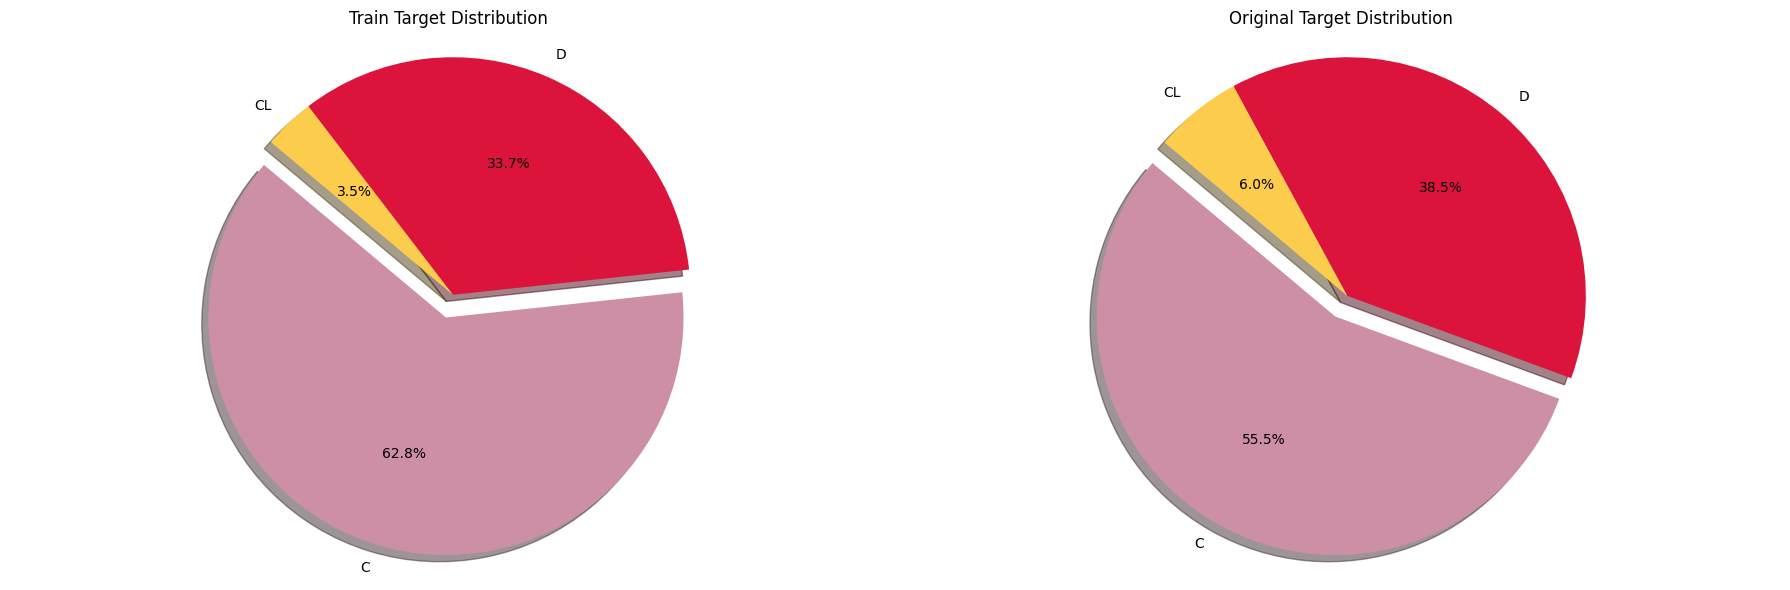

In [12]:
target='Status'
def plot_pie_chart(data, title, ax):
    data_counts = data[target].value_counts()
    labels = data_counts.index
    sizes = data_counts.values
    colors = [(0.8, 0.56, 0.65), 'crimson',  (0.99, 0.8, 0.3)]  
    explode = (0.1, 0, 0)  

    ax.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
    ax.axis('equal') 
    ax.set_title(title)

fig, axes = plt.subplots(1, 2, figsize=(18, 6))  # Create three subplots in a row

plot_pie_chart(train, "Train Target Distribution", axes[0])
plot_pie_chart(original, "Original Target Distribution", axes[1])

plt.tight_layout()
plt.show()

Original CL is bit more than train

**3.2 Numerical Feature Distribution**

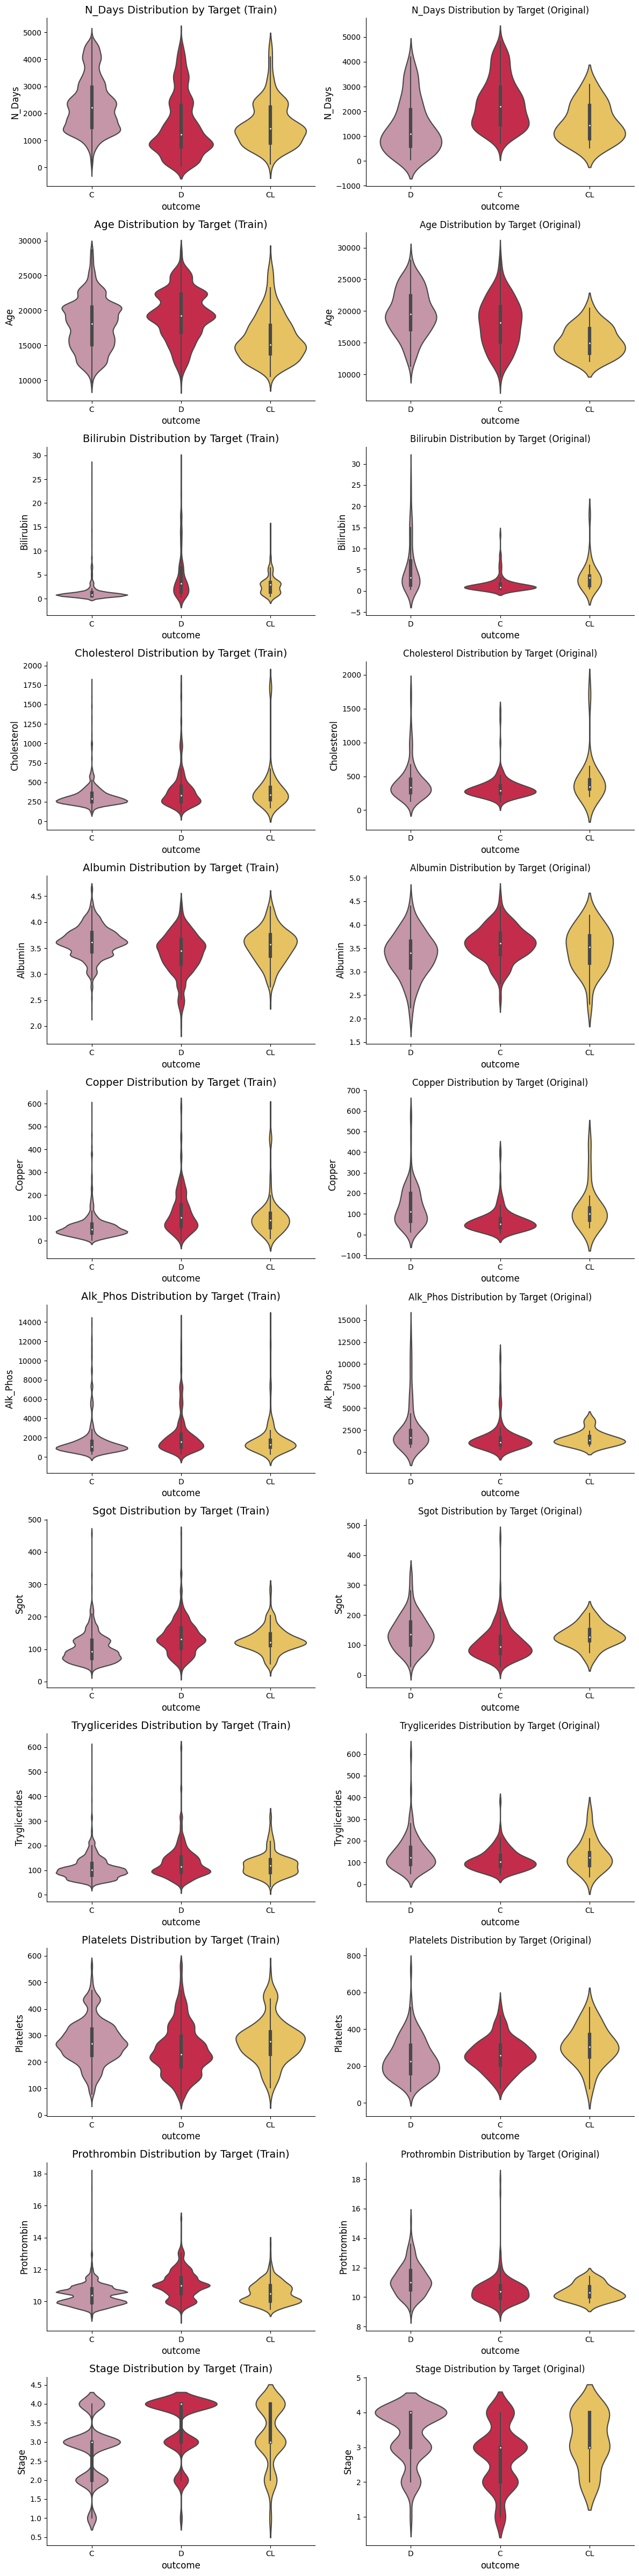

In [13]:
#num_cols = [column for column in total.columns if (total[column].nunique() > 10) & (column != target)]
num_cols = total.select_dtypes(include=['number']).columns.to_list()
n_rows = len(num_cols)
fig, axs = plt.subplots(n_rows, 2, figsize=(12, 4 * n_rows))
sns.set_palette([(0.8, 0.56, 0.65), 'crimson',  (0.99, 0.8, 0.3)]) 

for i, col in enumerate(num_cols):
    sns.violinplot(x=target, y=col, data=total, ax=axs[i, 0])
    axs[i, 0].set_title(f'{col.title()} Distribution by Target (Train)', fontsize=14)
    axs[i, 0].set_xlabel('outcome', fontsize=12)
    axs[i, 0].set_ylabel(col.title(), fontsize=12)
    sns.despine()

    sns.violinplot(x=target, y=col, data=original, ax=axs[i, 1])
    axs[i, 1].set_title(f'{col.title()} Distribution by Target (Original)', fontsize=12)
    axs[i, 1].set_xlabel('outcome', fontsize=12)
    axs[i, 1].set_ylabel(col.title(), fontsize=12)
    sns.despine()

fig.tight_layout()

plt.show()

Bilirubin has a important influence. Copper, Albumin, Cholestrol are good features.

**3.3 Categorical Features Analysis**

In [14]:
#extract category, numerical, binary cols
#category_cols = [column for column in train.columns if (train[column].nunique() <= 10) & (column != target)]
category_cols = total.select_dtypes(include=['object', 'category']).columns.to_list()
category_cols.remove('Status')
binary_cols = [column for column in train.columns if train[column].nunique() == 2]

In [15]:
category_cols

['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']

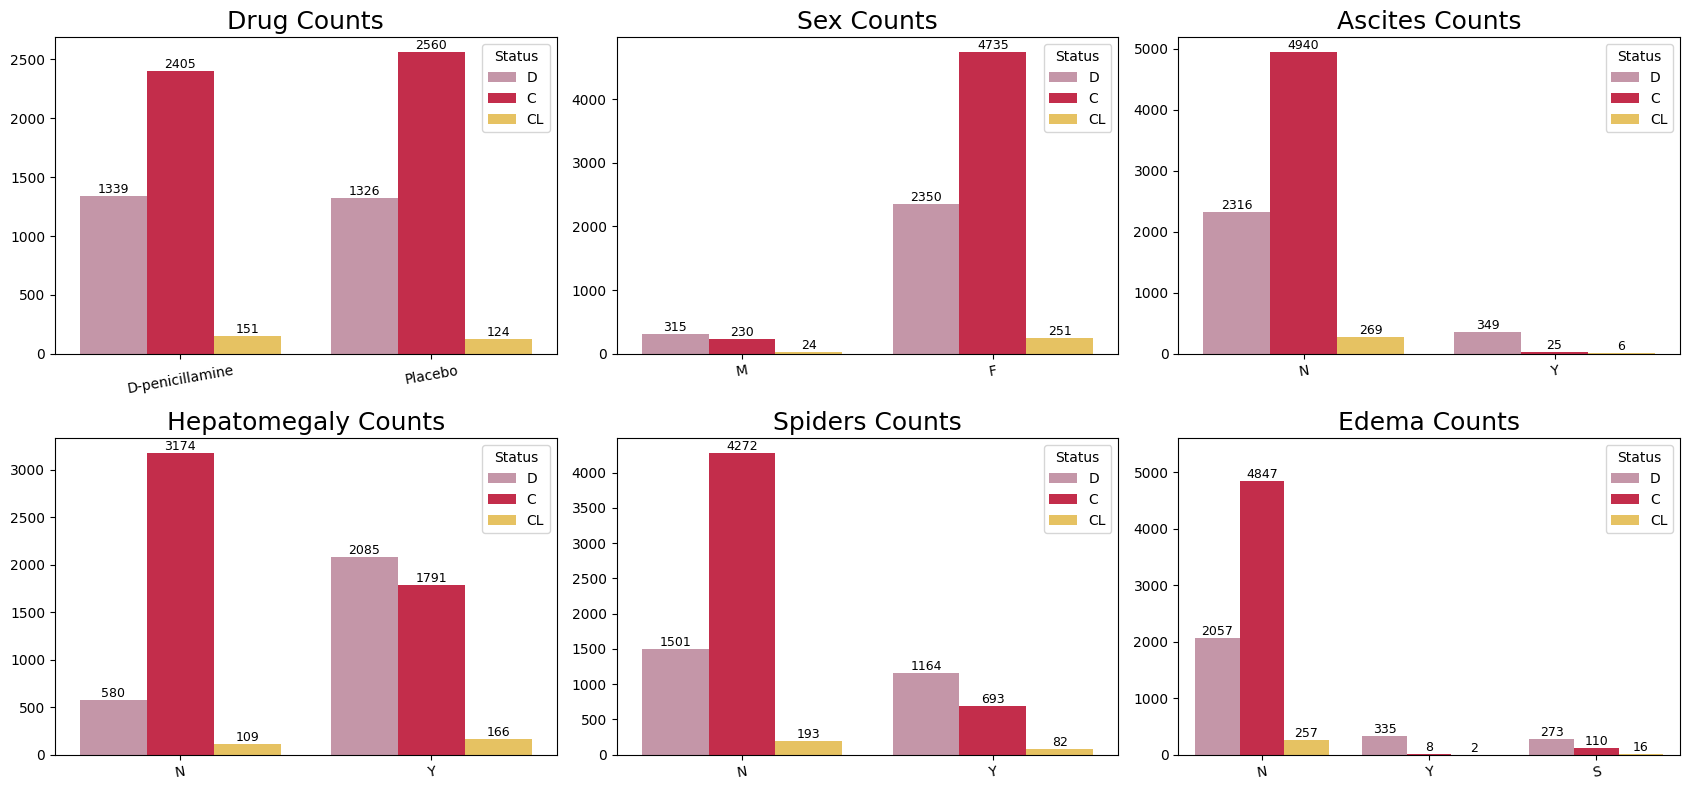

In [16]:


def plot_count(df,columns,n_cols,hue):
    '''
    # Function to genear countplot
    df: total data
    columns: category variables
    n_cols: num of cols
    '''
    n_rows = (len(columns) - 1) // n_cols + 1
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(17, 4 * n_rows))
    ax = ax.flatten()
    
    for i, column in enumerate(columns):
        sns.countplot(data=df, x=column, ax=ax[i],hue=hue)

        # Titles
        ax[i].set_title(f'{column} Counts', fontsize=18)
        ax[i].set_xlabel(None, fontsize=16)
        ax[i].set_ylabel(None, fontsize=16)
        ax[i].tick_params(axis='x', rotation=10)

        for p in ax[i].patches:
            value = int(p.get_height())
            ax[i].annotate(f'{value:.0f}', (p.get_x() + p.get_width() / 2, p.get_height()),
                           ha='center', va='bottom', fontsize=9)

    ylim_top = ax[i].get_ylim()[1]
    ax[i].set_ylim(top=ylim_top * 1.1)
    for i in range(len(columns), len(ax)):
        ax[i].axis('off')

    # fig.suptitle(plotname, fontsize=25, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
plot_count(train, category_cols, 3, 'Status')

Observations:\
All Drugs lead to same outcome distribution.\
Although, samples of male and female are inbalanced, it reveals different distribution.\
All these symptoms(Ascites, Hepatomegaly, Spiders, Edema) cuases a higher death rate.\
Deeper stage lead to larger death rate


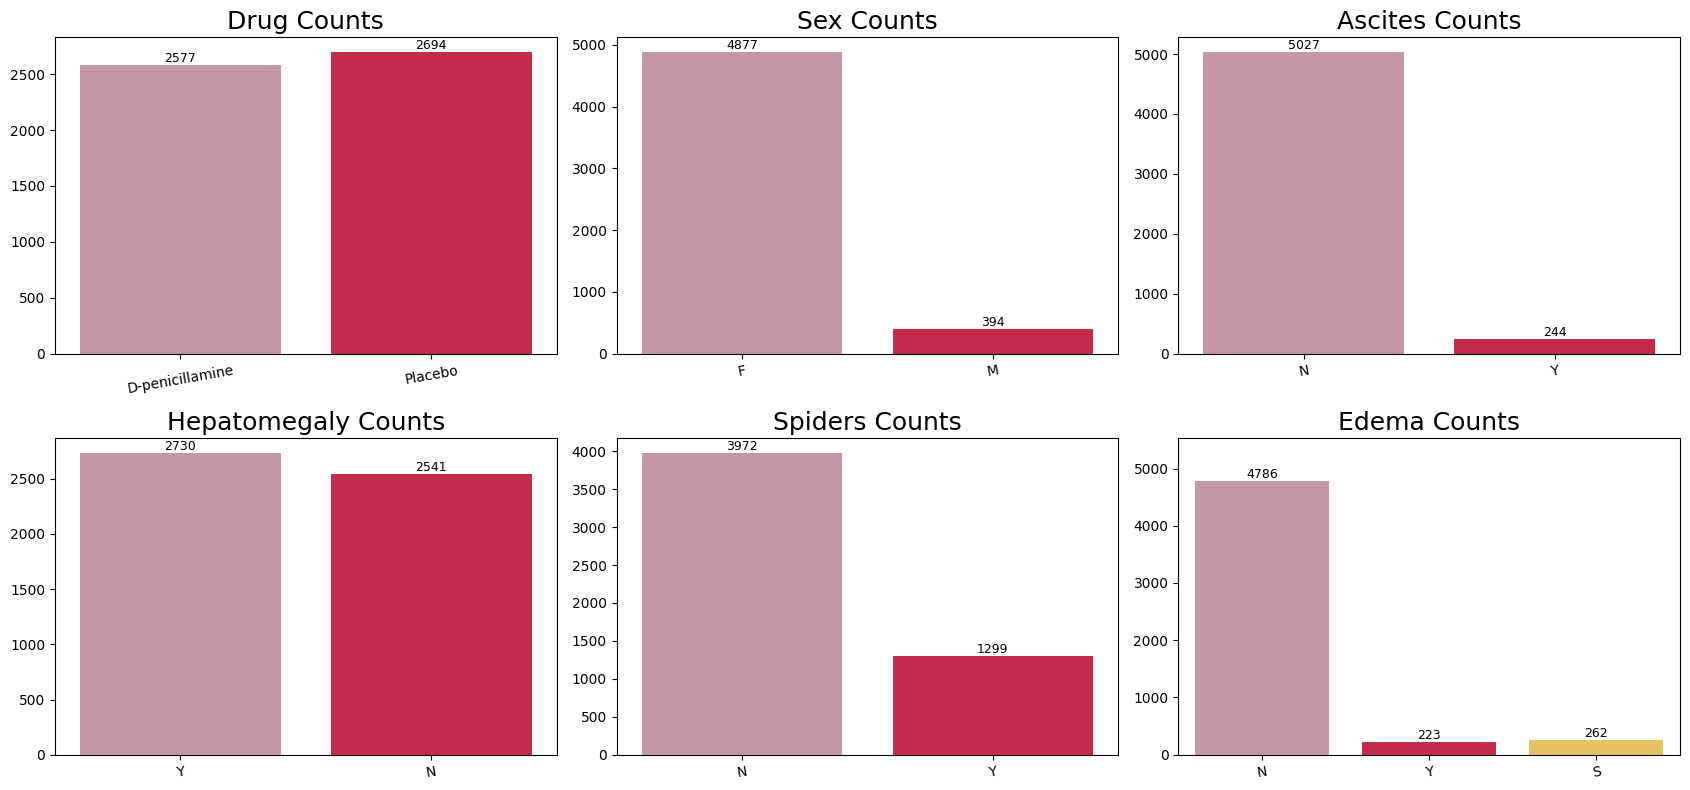

In [17]:
plot_count(test, category_cols, 3, None)

Observation:\
There are data imbalances in some features, which are manifested in:\
The sex counts contain a large number of male\

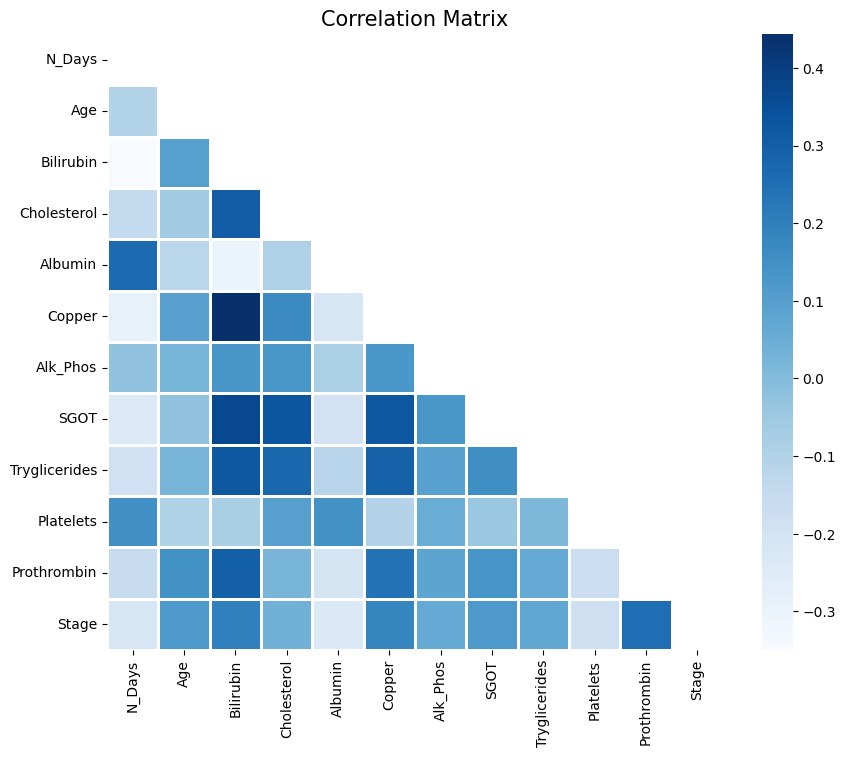

In [18]:
corr_matrix = total[num_cols].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='Blues', fmt='.2f', linewidths=1, square=True, annot_kws={"size": 9} )
plt.title('Correlation Matrix', fontsize=15)
plt.show()

There is no obvious multicolinearily

****4. Feature Engineering****

chi-squere check

In [ ]:
# def chi_squared_test(df, input_var, target_var, significance_level=0.05):
#     contingency_table = pd.crosstab(df[input_var], df[target_var])
#     chi2, p, _, _ = stats.chi2_contingency(contingency_table)
    
#     if p < significance_level:
#         print(f'\033[32m{input_var} has a significant relationship with the target variable.\033[0m') 
#     else:
#         print(f'\033[31m{input_var} does not have a significant relationship with the target variable.\033[0m')  

# for i in num_cols:
#     chi_squared_test(train, i, target)

# for i in category_cols:
#     chi_squared_test(train, i, target)

In [19]:
total[target] = total[target].map({'C':0,'CL':1,'D':2})

**4.1 Features Derivation**

TBD: derive Symptom_Score and Diagnosis_Date

In [81]:
ohe_cols = ['Edema', 'Stage']
deri_cols = []

In [82]:
total['Diagnosis_Date'] = total['Age'] - total['N_Days']# dat that you have disease
test['Diagnosis_Date'] = test['Age'] - test['N_Days']
num_cols.append('Diagnosis_Date')

In [83]:
total['Age_in_year'] = total['Age'] / 365.25 # dat that you have disease
test['Age_in_year'] = test['Age'] / 365.25
num_cols.append('Age_in_year')

In [84]:
total['Age_Group'] = pd.cut(total['Age_in_year'], bins=[19, 29, 49, 64, 99], labels = [0, 1, 2, 3]).astype('int16')
test['Age_Group'] = pd.cut(test['Age_in_year'], bins=[19, 29, 49, 64, 99], labels = [0, 1, 2, 3]).astype('int16')
deri_cols.append('Age_Group')

In [85]:
total.head() 

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status,Diagnosis_Date,Age_in_year,Age_Group,Bilirubin_level,Cholesterol_level,Albumin_level,Copper_level,Alk_Phos_level,Platelets_level,normal_sgot,Prothrombin_level,Diag_Year,Diag_Month
0,1216,Placebo,19295,F,N,N,N,N,0.8,263.0,4.30,51.0,1132.0,74.40,214.0,258.0,10.3,3.0,0,18079,52.826831,2,1,0,1,0,0,1,0,1,3,4
1,3059,D-penicillamine,19470,F,N,N,Y,N,0.9,232.0,4.09,13.0,1056.0,55.00,84.0,336.0,9.9,2.0,0,16411,53.305955,2,1,1,1,0,0,1,0,1,8,4
2,1569,D-penicillamine,19015,F,N,Y,N,N,3.6,310.0,3.80,105.0,820.0,85.25,101.0,121.0,9.6,4.0,0,17446,52.060233,2,0,0,1,1,0,0,0,1,4,3
3,943,D-penicillamine,12641,F,N,Y,N,N,1.0,434.0,3.40,121.0,836.0,84.00,111.0,336.0,10.0,3.0,0,11698,34.609172,1,1,0,1,1,0,1,0,1,2,7
4,140,D-penicillamine,20296,F,Y,Y,N,N,3.9,448.0,3.19,77.0,1716.0,175.15,175.0,228.0,11.0,4.0,2,20156,55.567420,2,0,0,0,1,0,1,0,1,0,4


In [86]:
normal_bilirubin_range = (0.2, 1.2)

total['Bilirubin_level'] = np.where((total['Bilirubin'] >= normal_bilirubin_range[0]) & (total['Bilirubin'] <= normal_bilirubin_range[1]), 1, 0)
test['Bilirubin_level'] = np.where((test['Bilirubin'] >= normal_bilirubin_range[0]) & (test['Bilirubin'] <= normal_bilirubin_range[1]), 1, 0)
deri_cols.append('Bilirubin_level')

In [87]:
normal_cholesterol_range = (200, 239)

total['Cholesterol_level'] = np.where((total['Cholesterol'] >= normal_cholesterol_range[0]) & (total['Cholesterol'] <= normal_cholesterol_range[1]), 1, 0)

test['Cholesterol_level'] = np.where((test['Cholesterol'] >= normal_cholesterol_range[0]) & (test['Cholesterol'] <= normal_cholesterol_range[1]), 1, 0)

deri_cols.append('Cholesterol_level')

In [88]:
#Albumin grouping
normal_albumin_range = (3.4, 5.4)

total['Albumin_level'] = np.where((total['Albumin'] >= normal_albumin_range[0]) & (total['Albumin'] <= normal_albumin_range[1]), 1, 0)

test['Albumin_level'] = np.where((test['Albumin'] >= normal_albumin_range[0]) & (test['Albumin'] <= normal_albumin_range[1]), 1, 0)
deri_cols.append('Albumin_level')

In [89]:
#copper grouping
normal_copper_range = (62, 140)

total['Copper_level'] = np.where((total['Copper'] >= normal_copper_range[0]) & (total['Copper'] <= normal_copper_range[1]), 1, 0)

test['Copper_level'] = np.where((test['Copper'] >= normal_copper_range[0]) & (test['Copper'] <= normal_copper_range[1]), 1, 0)
deri_cols.append('Copper_level')

In [90]:
#Alk_Phos grouping
normal_Alk_range = (44, 147)

total['Alk_Phos_level'] = np.where((total['Alk_Phos'] >= normal_Alk_range[0]) & (total['Alk_Phos'] <= normal_Alk_range[1]), 1, 0)

test['Alk_Phos_level'] = np.where((test['Alk_Phos'] >= normal_Alk_range[0]) & (test['Alk_Phos'] <= normal_Alk_range[1]), 1, 0)
deri_cols.append('Alk_Phos_level')

In [91]:
#Platelets grouping

normal_Platelets_range = (150, 450)

total['Platelets_level'] = np.where((total['Platelets'] >= normal_Platelets_range[0]) & (total['Platelets'] <= normal_Platelets_range[1]), 1, 0)

test['Platelets_level'] = np.where((test['Platelets'] >= normal_Platelets_range[0]) & (test['Platelets'] <= normal_Platelets_range[1]), 1, 0)
deri_cols.append('Platelets_level')

In [92]:
#Tryglicerides gruping
    
# normal_Tryglicerides_range = (150, 199)

# total['Tryglicerides_level'] = np.where((total['Tryglicerides'] >= normal_Tryglicerides_range[0]) & (total['Tryglicerides'] <= normal_Tryglicerides_range[1]), 1, 0)

# test['Tryglicerides_level'] = np.where((test['Tryglicerides'] >= normal_Tryglicerides_range[0]) & (test['Tryglicerides'] <= normal_Tryglicerides_range[1]), 1, 0)
# deri_cols.append('Tryglicerides_level')
normal_sgot_range = (8,45)
total['normal_sgot'] = np.where((total['SGOT'] >= normal_sgot_range[0]) & (total['SGOT'] <= normal_sgot_range[1]), 1, 0)
test['normal_sgot'] = np.where((test['SGOT'] >= normal_sgot_range[0]) & (test['SGOT'] <= normal_sgot_range[1]), 1, 0)
deri_cols.append('normal_sgot')

In [93]:
#Prothrombin
normal_Prothrombin_range = (9.4, 12.5)

total['Prothrombin_level'] = np.where((total['Prothrombin'] >= normal_Prothrombin_range[0]) & (total['Prothrombin'] <= normal_Prothrombin_range[1]), 1, 0)

test['Prothrombin_level'] = np.where((test['Prothrombin'] >= normal_Prothrombin_range[0]) & (test['Prothrombin'] <= normal_Prothrombin_range[1]), 1, 0)
deri_cols.append('Prothrombin_level')

In [94]:
total['Diag_Year'] = (total['N_Days'] / 365).astype(int)
total['Diag_Month'] = ((total['N_Days'] % 365) / 30).astype(int)
test['Diag_Year'] = (test['N_Days'] / 365).astype(int)
test['Diag_Month'] = ((test['N_Days'] % 365) / 30).astype(int)
num_cols.append('Diag_Year')
num_cols.append('Diag_Month')

In [95]:
total.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status,Diagnosis_Date,Age_in_year,Age_Group,Bilirubin_level,Cholesterol_level,Albumin_level,Copper_level,Alk_Phos_level,Platelets_level,normal_sgot,Prothrombin_level,Diag_Year,Diag_Month
0,1216,Placebo,19295,F,N,N,N,N,0.8,263.0,4.30,51.0,1132.0,74.40,214.0,258.0,10.3,3.0,0,18079,52.826831,2,1,0,1,0,0,1,0,1,3,4
1,3059,D-penicillamine,19470,F,N,N,Y,N,0.9,232.0,4.09,13.0,1056.0,55.00,84.0,336.0,9.9,2.0,0,16411,53.305955,2,1,1,1,0,0,1,0,1,8,4
2,1569,D-penicillamine,19015,F,N,Y,N,N,3.6,310.0,3.80,105.0,820.0,85.25,101.0,121.0,9.6,4.0,0,17446,52.060233,2,0,0,1,1,0,0,0,1,4,3
3,943,D-penicillamine,12641,F,N,Y,N,N,1.0,434.0,3.40,121.0,836.0,84.00,111.0,336.0,10.0,3.0,0,11698,34.609172,1,1,0,1,1,0,1,0,1,2,7
4,140,D-penicillamine,20296,F,Y,Y,N,N,3.9,448.0,3.19,77.0,1716.0,175.15,175.0,228.0,11.0,4.0,2,20156,55.567420,2,0,0,0,1,0,1,0,1,0,4


**4.2 Feature Scaling and Encoding**

In [96]:
if 'Stage' in num_cols:
    num_cols.remove('Stage')

In [97]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def preprocessing(df, bin_cols, ohe_cols, num_cols, remain_cols):
    
    # Label Encoding for binary cols
    le = LabelEncoder()    
    df_le = pd.DataFrame(columns = bin_cols)
    for col in bin_cols:
        df_le[col] = le.fit_transform(df[col])
    
    # OneHot Encoding for category cols
    df_ohe = pd.get_dummies(df[ohe_cols], columns = ohe_cols)
    df_ohe = df_ohe.replace({True: 1, False: 0})
    
    #scaling
    sc = StandardScaler()
    scaled_num = pd.DataFrame(sc.fit_transform(df[num_cols]),columns = num_cols)
    
    df_new = pd.concat([df_le, df_ohe, scaled_num, df[remain_cols]], axis =1)
    
    return df_new

In [99]:
num_cols

['N_Days',
 'Age',
 'Bilirubin',
 'Cholesterol',
 'Albumin',
 'Copper',
 'Alk_Phos',
 'SGOT',
 'Tryglicerides',
 'Platelets',
 'Prothrombin',
 'Diagnosis_Date',
 'Age_in_year',
 'Diag_Year',
 'Diag_Month']

In [100]:
train_ = preprocessing(total, binary_cols, ohe_cols, num_cols, deri_cols)
test_ = preprocessing(test, binary_cols, ohe_cols, num_cols, deri_cols)

In [101]:
#symptom score
symptom_columns = ['Ascites', 'Hepatomegaly', 'Spiders', 'Edema_N', 'Edema_S', 'Edema_Y']
train_['Symptom_Score'] = train_[symptom_columns].sum(axis=1)
test_['Symptom_Score'] = test_[symptom_columns].sum(axis=1)

In [102]:
display(train_.head(), test_.head())

,Drug,Sex,Ascites,Hepatomegaly,Spiders,Edema_N,Edema_S,Edema_Y,Stage_1.0,Stage_2.0,Stage_3.0,Stage_4.0,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Diagnosis_Date,Age_in_year,Diag_Year,Diag_Month,Age_Group,Bilirubin_level,Cholesterol_level,Albumin_level,Copper_level,Alk_Phos_level,Platelets_level,normal_sgot,Prothrombin_level,Symptom_Score
0,1,0,0,0,0,1,0,0,0,0,1,0,-0.742133,0.251828,-0.473323,-0.448377,2.161148,-0.438118,-0.361438,-0.825328,1.854286,-0.081142,-0.421279,0.440434,0.251828,-0.679697,-0.448632,2,1,0,1,0,0,1,0,1,1
1,0,0,0,0,1,1,0,0,0,1,0,0,0.941351,0.299314,-0.447308,-0.605862,1.558229,-0.935506,-0.401201,-1.220421,-0.597109,0.808727,-0.927260,0.018348,0.299314,0.971215,-0.448632,2,1,1,1,0,0,1,0,1,2
2,0,0,0,1,0,1,0,0,0,0,0,1,-0.419686,0.175850,0.255097,-0.209609,0.725628,0.268697,-0.524678,-0.604361,-0.276542,-1.644115,-1.306745,0.280254,0.175850,-0.349515,-0.732861,2,0,0,1,1,0,0,0,1,2
3,0,0,0,1,0,1,0,0,0,0,1,0,-0.991504,-1.553736,-0.421293,0.420332,-0.422788,0.478123,-0.516307,-0.629818,-0.087973,0.808727,-0.800765,-1.174274,-1.553736,-1.009880,0.404057,1,1,0,1,1,0,1,0,1,2
4,0,0,1,1,0,1,0,0,0,0,0,1,-1.725002,0.523449,0.333142,0.491454,-1.025706,-0.097800,-0.055885,1.226506,1.118867,-0.423398,0.464187,0.966018,0.523449,-1.670245,-0.448632,2,0,0,0,1,0,1,0,1,3


,Drug,Sex,Ascites,Hepatomegaly,Spiders,Edema_N,Edema_S,Edema_Y,Stage_1.0,Stage_2.0,Stage_3.0,Stage_4.0,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Diagnosis_Date,Age_in_year,Diag_Year,Diag_Month,Age_Group,Bilirubin_level,Cholesterol_level,Albumin_level,Copper_level,Alk_Phos_level,Platelets_level,normal_sgot,Prothrombin_level,Symptom_Score
0,0,0,0,1,0,1,0,0,0,1,0,0,1.656608,0.342186,-0.363546,0.965540,-0.473636,-0.254101,-0.090552,0.782524,-0.480744,1.895231,-0.041463,-0.148583,0.342186,1.630078,0.122482,2,1,0,0,1,0,1,0,1,2
1,0,0,0,0,0,1,0,0,0,1,0,0,0.395038,-0.983033,-0.389506,1.534346,1.921728,0.119925,-0.286401,0.782524,0.755049,-0.422762,-0.798430,-1.022907,-0.983033,0.302594,0.971588,1,1,0,1,1,0,1,0,1,1
2,1,0,0,1,0,0,0,1,0,0,0,1,-1.829045,-1.492582,-0.155863,-1.005321,-1.629046,-0.499153,-0.439359,-0.895372,-0.271610,-0.582624,2.986409,-0.869939,-1.492582,-1.688632,-1.292694,1,0,0,0,0,0,1,0,0,2
3,0,0,0,0,0,1,0,0,0,1,0,0,0.268052,0.561521,-0.519308,-0.296809,0.879041,-0.576538,-0.649677,0.244331,-1.127159,0.068241,-0.041463,0.445429,0.561521,0.302594,-0.443588,2,1,0,1,0,0,1,0,1,1
4,0,0,0,1,0,1,0,0,1,0,0,0,-0.389878,0.950520,-0.311625,-0.376641,-1.600866,0.468156,-0.362363,0.233097,0.203695,-0.491274,-1.050753,0.991299,0.950520,-0.361148,-0.160553,2,0,0,0,1,0,1,0,1,2


In [103]:
train_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8181 entries, 0 to 8180
Data columns (total 37 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Drug               8181 non-null   int64  
 1   Sex                8181 non-null   int64  
 2   Ascites            8181 non-null   int64  
 3   Hepatomegaly       8181 non-null   int64  
 4   Spiders            8181 non-null   int64  
 5   Edema_N            8181 non-null   int64  
 6   Edema_S            8181 non-null   int64  
 7   Edema_Y            8181 non-null   int64  
 8   Stage_1.0          8181 non-null   int64  
 9   Stage_2.0          8181 non-null   int64  
 10  Stage_3.0          8181 non-null   int64  
 11  Stage_4.0          8181 non-null   int64  
 12  N_Days             8181 non-null   float64
 13  Age                8181 non-null   float64
 14  Bilirubin          8181 non-null   float64
 15  Cholesterol        8181 non-null   float64
 16  Albumin            8181 

**4.3 Feature Selection**

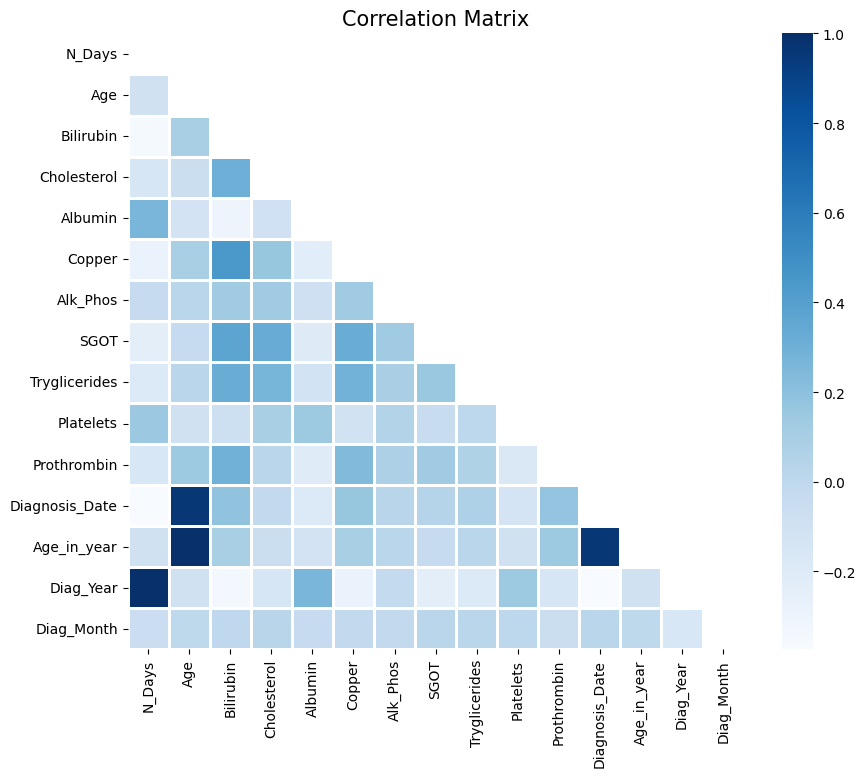

In [104]:
corr_matrix = train_[num_cols].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='Blues', fmt='.2f', linewidths=1, square=True, annot_kws={"size": 9} )
plt.title('Correlation Matrix', fontsize=15)
plt.show()

Removing the correlated columns, it is very necessary to reduce overfitting

In [106]:
train_.drop('Diagnosis_Date', axis=1, inplace=True)
test_.drop('Diagnosis_Date', axis=1, inplace=True)

In [108]:
train_.drop('Age_in_year', axis=1, inplace=True)
test_.drop('Age_in_year', axis=1, inplace=True)

In [ ]:
train_.drop('Diag_Year', axis=1, inplace=True)
test_.drop('Diag_Year', axis=1, inplace=True)

In [109]:
train_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8181 entries, 0 to 8180
Data columns (total 34 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Drug               8181 non-null   int64  
 1   Sex                8181 non-null   int64  
 2   Ascites            8181 non-null   int64  
 3   Hepatomegaly       8181 non-null   int64  
 4   Spiders            8181 non-null   int64  
 5   Edema_N            8181 non-null   int64  
 6   Edema_S            8181 non-null   int64  
 7   Edema_Y            8181 non-null   int64  
 8   Stage_1.0          8181 non-null   int64  
 9   Stage_2.0          8181 non-null   int64  
 10  Stage_3.0          8181 non-null   int64  
 11  Stage_4.0          8181 non-null   int64  
 12  N_Days             8181 non-null   float64
 13  Age                8181 non-null   float64
 14  Bilirubin          8181 non-null   float64
 15  Cholesterol        8181 non-null   float64
 16  Albumin            8181 

In [ ]:
#XGBoost parameters
xgb_params = {'max_depth': 6,
          'min_child_weight': 10,
          'learning_rate': 0.010009541152584345, 
          'n_estimators': 1878, 'subsample': 0.47524425009347593, 
          'colsample_bytree': 0.3292032860985591, 'random_state': 42,

         'tree_method': 'hist', 
        'eval_metric': 'mlogloss', 
          'device' : 'cuda',
        'verbosity': 2}

**5. Model**

In [110]:
def boost_cross_val(model, n_splits, X, y):
    # StratifiedKFold
    stratkf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    cv_results = []

    for fold, (train_idx, val_idx) in enumerate(stratkf.split(X, y)):

        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        model.fit(X_train,y_train)

        y_val_pred_prob = model.predict_proba(X_val)

        logloss = log_loss(y_val, y_val_pred_prob)
        print(f'Fold {fold + 1}, Logarithmic Loss on Validation Set: {logloss}')

        cv_results.append(logloss)
    average_cv_result = sum(cv_results) / n_splits
    print(f'\nAverage Logarithmic Loss across {n_splits} folds: {average_cv_result}')
    return cv_results

**5.1 XGBClassifier**

In [111]:
X = train_
y = total['Status']

In [112]:
#optuna opt params
import optuna

import warnings

# # Suppress FutureWarnings related to is_sparse
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.utils.validation")

def objective_xgb(trial):
    params = {'objective': 'multi:softprob',
              'num_class': 3,  # Assuming 3 classes for multi-class classification
              'max_depth': trial.suggest_int('max_depth', 5, 10),
              'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
              'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
              'n_estimators': trial.suggest_int('n_estimators', 50, 2000),
              'subsample': trial.suggest_float('subsample', 0.01, 1.0),\
              'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
              'random_state': trial.suggest_categorical('random_state', [42]),
              'tree_method': 'hist',  # Use GPU for training
              'device' : 'cuda',
              'eval_metric': 'mlogloss',  # Evaluation metric
              'verbosity': 0,  # Set verbosity to 0 for less output
             }
    xgb_model = XGBClassifier(**params)

    cv = abs(cross_val_score(xgb_model, X, y, cv=10, scoring='neg_log_loss').mean())
    return cv

study = optuna.create_study(direction='minimize')
study.optimize(objective_xgb, n_trials=50)
best_params = study.best_params
print("Best Hyperparameters of XGBClassifier:", best_params)

[I 2024-01-01 15:54:18,901] A new study created in memory with name: no-name-7ec85f01-de83-4519-aae5-22ccaaac5b02
[I 2024-01-01 15:55:27,858] Trial 0 finished with value: 0.9951404034465693 and parameters: {'max_depth': 9, 'min_child_weight': 3, 'learning_rate': 0.5395367286712497, 'n_estimators': 1784, 'subsample': 0.2548692899041235, 'colsample_bytree': 0.6070885769308402, 'random_state': 42}. Best is trial 0 with value: 0.9951404034465693.
[I 2024-01-01 15:56:28,478] Trial 1 finished with value: 0.58489586332306 and parameters: {'max_depth': 10, 'min_child_weight': 7, 'learning_rate': 0.22672667183863818, 'n_estimators': 1107, 'subsample': 0.4773096095986959, 'colsample_bytree': 0.12616534632637919, 'random_state': 42}. Best is trial 1 with value: 0.58489586332306.
[I 2024-01-01 15:57:32,649] Trial 2 finished with value: 0.4655295856275277 and parameters: {'max_depth': 7, 'min_child_weight': 7, 'learning_rate': 0.040748142699039404, 'n_estimators': 1070, 'subsample': 0.6927738478542

Best Hyperparameters of XGBClassifier: {'max_depth': 10, 'min_child_weight': 1, 'learning_rate': 0.06168800018782131, 'n_estimators': 321, 'subsample': 0.546438474850606, 'colsample_bytree': 0.08217761725549018, 'random_state': 42}


In [113]:
#XGBoost parameters
# xgb_params = {'max_depth': 6,
#           'min_child_weight': 10,
#           'learning_rate': 0.010009541152584345, 
#           'n_estimators': 1878, 'subsample': 0.47524425009347593, 
#           'colsample_bytree': 0.3292032860985591, 'random_state': 42,

#          'tree_method': 'hist', 
#         'eval_metric': 'mlogloss', 
#           'device' : 'cuda',
#         'verbosity': 2}

# xgb_params = {
#     'max_depth': 7,
#     'min_child_weight': 10, 
#     'learning_rate': 0.01846443961218827, 
#     'n_estimators': 1148, 
#     'subsample': 0.9464494118007915, 
#     'colsample_bytree': 0.08265883034531843, 
#     'random_state': 42,
#     'tree_method': 'hist', 
#     'eval_metric': 'mlogloss', 
#     'device' : 'cuda',
#     'verbosity': 2
# }
xgb_params = {
    'max_depth': 10, 
    'min_child_weight': 1, 
    'learning_rate': 0.06168800018782131, 
    'n_estimators': 321, 
    'subsample': 0.546438474850606, 
    'colsample_bytree': 0.08217761725549018, 
    'random_state': 42,
    
    'tree_method': 'hist', 
    'eval_metric': 'mlogloss', 
    'device' : 'cuda',
    'verbosity': 2
}


xgb_model = XGBClassifier(**xgb_params)
boost_cross_val(xgb_model, 10, X, y)

Fold 1, Logarithmic Loss on Validation Set: 0.3946452823136581
Fold 2, Logarithmic Loss on Validation Set: 0.4449697198522985
Fold 3, Logarithmic Loss on Validation Set: 0.4053713906969644
Fold 4, Logarithmic Loss on Validation Set: 0.43270478137704615
Fold 5, Logarithmic Loss on Validation Set: 0.4055474526494063
Fold 6, Logarithmic Loss on Validation Set: 0.42230267383838593
Fold 7, Logarithmic Loss on Validation Set: 0.4078458165589666
Fold 8, Logarithmic Loss on Validation Set: 0.413707131900594
Fold 9, Logarithmic Loss on Validation Set: 0.4144955551676325
Fold 10, Logarithmic Loss on Validation Set: 0.3940500755009909

Average Logarithmic Loss across 10 folds: 0.4135639879855943


[0.3946452823136581,
 0.4449697198522985,
 0.4053713906969644,
 0.43270478137704615,
 0.4055474526494063,
 0.42230267383838593,
 0.4078458165589666,
 0.413707131900594,
 0.4144955551676325,
 0.3940500755009909]

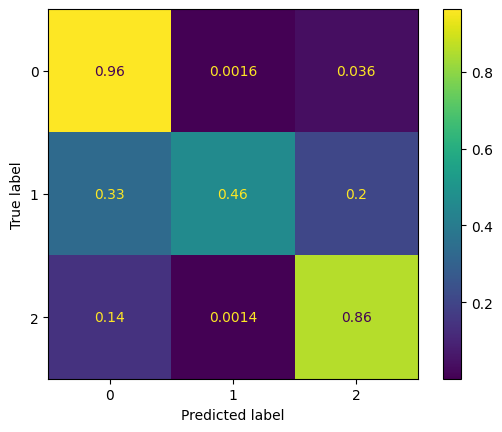

In [114]:
y_pred = xgb_model.predict(X)
ConfusionMatrixDisplay.from_predictions(y, y_pred, normalize='true')
plt.show()

Accuracy of CL(1 class) is extremely low. Because the dataset of CL class is much less.

In [ ]:
from sklearn.feature_selection import RFECV
rfe = RFECV(estimator=xgb_model, min_features_to_select=1, step=1, n_jobs=-1, verbose=1)

# Preliminary, should be done of course in a train-val loop
rfe.fit(X, y)

print("Feature Ranking: ", rfe.ranking_)

In [127]:
X_copy = X.copy()
rfe.transform(X_copy)

sel_feats = X_copy.columns[rfe.support_].values
print(len(sel_feats))
print(sel_feats.tolist())

28
['Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema_N', 'Edema_S', 'Edema_Y', 'N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Diagnosis_Date', 'Bilirubin_level', 'Cholesterol_level', 'Albumin_level', 'Copper_level', 'Platelets_level', 'Tryglicerides_level', 'Prothrombin_level', 'Stage', 'Symptom_Score']


In [128]:
boost_cross_val(xgb_model, 10, X[sel_feats], y)

Fold 1, Logarithmic Loss on Validation Set: 0.4384156977233116
Fold 2, Logarithmic Loss on Validation Set: 0.4252907882450827
Fold 3, Logarithmic Loss on Validation Set: 0.38310354892408527
Fold 4, Logarithmic Loss on Validation Set: 0.4538509428998617
Fold 5, Logarithmic Loss on Validation Set: 0.4445127785241054
Fold 6, Logarithmic Loss on Validation Set: 0.42184770993040394
Fold 7, Logarithmic Loss on Validation Set: 0.42730499299129077
Fold 8, Logarithmic Loss on Validation Set: 0.4151747318961262
Fold 9, Logarithmic Loss on Validation Set: 0.43457242638253774
Fold 10, Logarithmic Loss on Validation Set: 0.40824771631879864

Average Logarithmic Loss across 10 folds: 0.42523213338356036


[0.4384156977233116,
 0.4252907882450827,
 0.38310354892408527,
 0.4538509428998617,
 0.4445127785241054,
 0.42184770993040394,
 0.42730499299129077,
 0.4151747318961262,
 0.43457242638253774,
 0.40824771631879864]

In [115]:
def f_importance_plot(f_imp):
    fig = plt.figure(figsize=(12, 0.20*len(f_imp)))
    plt.title(f'Feature importances', size=16, y=1.05, 
              fontweight='bold')
    a = sns.barplot(data=f_imp, x='imp', y='feature', linestyle="-", 
                    linewidth=0.5, edgecolor="black",palette='GnBu')
    plt.xlabel('')
    plt.xticks([])
    plt.ylabel('')
    plt.yticks(size=11)
    
    for j in ['right', 'top', 'bottom']:
        a.spines[j].set_visible(False)
    for j in ['left']:
        a.spines[j].set_linewidth(0.5)
    plt.tight_layout()
    plt.show()

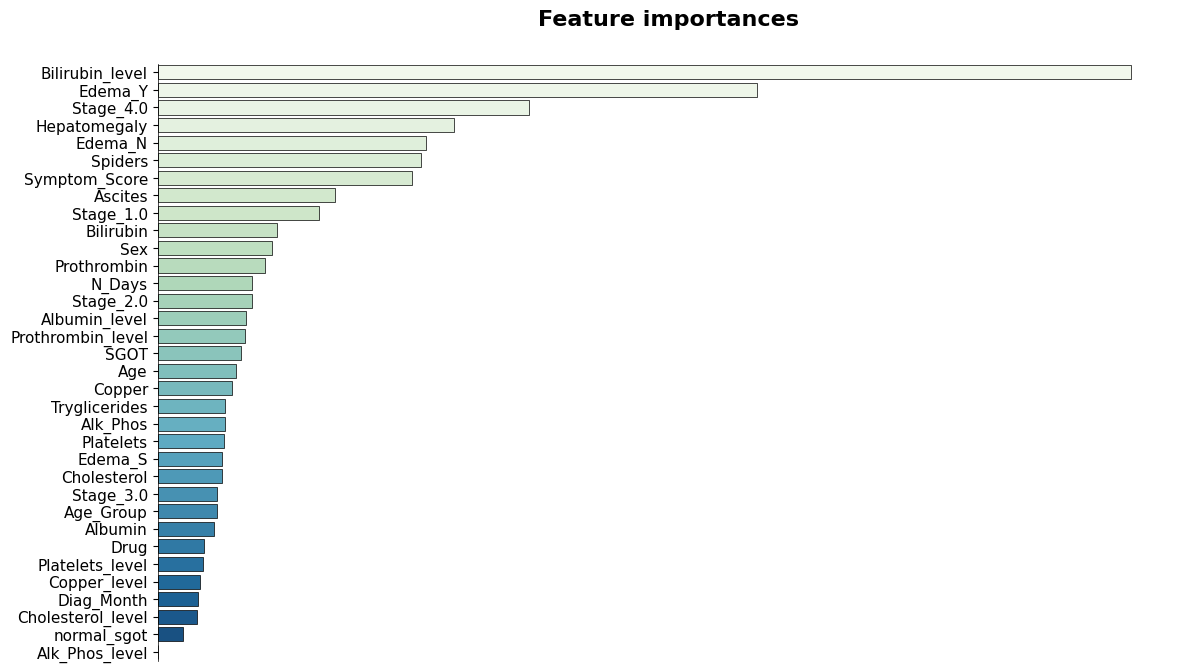

In [116]:
f_imp_df = pd.DataFrame({'feature': X.columns, 'imp': xgb_model.feature_importances_})
f_imp_df.sort_values(by='imp',ascending=False,inplace=True)
f_importance_plot(f_imp_df)

**5.2 LGBMClassifier**

In [ ]:
#optuna opt params
def objective_lgbm(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'max_depth': trial.suggest_int('max_depth', 5, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 15),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'random_state': 42,
        'objective': 'multi_logloss',
        'device': 'gpu',
    }
    lgbm_model = LGBMClassifier(**params)

    cv = abs(cross_val_score(lgbm_model, X, y, cv=10, scoring='neg_log_loss').mean())
    return cv

study = optuna.create_study(direction='minimize')
study.optimize(objective_lgbm, n_trials=50)
lgbm_best_params = study.best_params
print("Best Hyperparameters of LGBMClassifier:", lgbm_best_params)

In [120]:
lgbm_params = {'objective': 'multi_logloss', 
               'max_depth': 9, 
               'min_child_samples': 14, 
               'learning_rate': 0.034869481921747415, 
               'n_estimators': 274, 
               'min_child_weight': 9, 
               'subsample': 0.7717873512945741, 
               'colsample_bytree': 0.1702910221565107, 
               'reg_alpha': 0.10626128775335533, 
               'reg_lambda': 0.624196407787772, 
               'random_state': 42,
              }

# lgbm_params = {
#     'objective': 'multi_logloss', 
#     'n_estimators': 200, 
#     'learning_rate': 0.08096622077649304, 
#     'max_depth': 9, 
#     'min_child_weight': 1, 
#     'min_child_samples': 12, 
#     'subsample': 0.08458883667785194, 
#     'colsample_bytree': 0.11220485468323299,
#     'random_state': 42,
# }
# lgbm_params = {
#     'objective': 'multi_logloss', 
#     'n_estimators': 149, 
#     'learning_rate': 0.0680051289617914,
#     'max_depth': 5, 
#     'min_child_weight': 10, 
#     'min_child_samples': 5, 
#     'subsample': 0.8802350383739656, 
#     'colsample_bytree': 0.9205932487882259,
#     'reg_alpha': 0.10626128775335533, 
#     'reg_lambda': 0.624196407787772, 
#     'random_state': 42
# }

lgbm_model = LGBMClassifier(**lgbm_params)
boost_cross_val(lgbm_model, 10, X, y)

Fold 1, Logarithmic Loss on Validation Set: 0.4046971162404935
Fold 2, Logarithmic Loss on Validation Set: 0.4399097833139605
Fold 3, Logarithmic Loss on Validation Set: 0.4165768848711058
Fold 4, Logarithmic Loss on Validation Set: 0.4452550003662178
Fold 5, Logarithmic Loss on Validation Set: 0.4020786502765747
Fold 6, Logarithmic Loss on Validation Set: 0.433148699892485
Fold 7, Logarithmic Loss on Validation Set: 0.42645149711966196
Fold 8, Logarithmic Loss on Validation Set: 0.42038499165845433
Fold 9, Logarithmic Loss on Validation Set: 0.4209819966217619
Fold 10, Logarithmic Loss on Validation Set: 0.4062792187426421

Average Logarithmic Loss across 10 folds: 0.42157638391033575


[0.4046971162404935,
 0.4399097833139605,
 0.4165768848711058,
 0.4452550003662178,
 0.4020786502765747,
 0.433148699892485,
 0.42645149711966196,
 0.42038499165845433,
 0.4209819966217619,
 0.4062792187426421]

**5.3 CatBoostClassifier**

In [121]:
#optuna opt params
def objective_cb(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 600),
        'depth': trial.suggest_int('depth', 3, 50),         
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 2, 50),         
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.2, log=True),
        'bootstrap_type' : 'Bernoulli',
        'random_state': 42,
        'grow_policy':'Lossguide'
    }
    cb_model = CatBoostClassifier(**params, verbose=0)

    cv = abs(cross_val_score(cb_model, X, y, cv=10, scoring='neg_log_loss').mean())
    return cv

study = optuna.create_study(direction='minimize')
study.optimize(objective_cb, n_trials=50)
cb_best_params = study.best_params
print("Best Hyperparameters of CatBoostClassifier:", cb_best_params)

[I 2024-01-01 17:16:23,696] A new study created in memory with name: no-name-6dfbc659-1006-4d71-bdec-32961b877257
[I 2024-01-01 17:17:02,356] Trial 0 finished with value: 0.5895144602790984 and parameters: {'iterations': 319, 'depth': 18, 'min_data_in_leaf': 8, 'learning_rate': 0.004481877369302008}. Best is trial 0 with value: 0.5895144602790984.
[I 2024-01-01 17:17:54,287] Trial 1 finished with value: 0.4627612530708413 and parameters: {'iterations': 596, 'depth': 38, 'min_data_in_leaf': 13, 'learning_rate': 0.19376923627338463}. Best is trial 1 with value: 0.4627612530708413.
[I 2024-01-01 17:18:48,146] Trial 2 finished with value: 0.9243336853158691 and parameters: {'iterations': 461, 'depth': 27, 'min_data_in_leaf': 20, 'learning_rate': 0.0004849899413392055}. Best is trial 1 with value: 0.4627612530708413.
[I 2024-01-01 17:19:02,682] Trial 3 finished with value: 0.4392778291876606 and parameters: {'iterations': 142, 'depth': 33, 'min_data_in_leaf': 40, 'learning_rate': 0.10821821

Best Hyperparameters of CatBoostClassifier: {'iterations': 426, 'depth': 25, 'min_data_in_leaf': 30, 'learning_rate': 0.06144679632305192}


In [122]:
from catboost import CatBoostClassifier
# catboost_params = {'iterations': 469,
#                    'depth': 20, 
#                    'min_data_in_leaf': 11,
#                    'learning_rate': 0.13812945166006543, 
#                    'grow_policy': 'Lossguide',
#                    'bootstrap_type' : 'Bernoulli'}
# catboost_params = {
#     'iterations': 423, 
#     'depth': 37, 
#     'min_data_in_leaf': 43, 
#     'learning_rate': 0.05930578426665686,
#     'grow_policy': 'Lossguide',
#     'bootstrap_type' : 'Bernoulli'
# }

catboost_params = {
    'iterations': 426,
    'depth': 25, 
    'min_data_in_leaf': 30, 
    'learning_rate': 0.06144679632305192,
    'grow_policy': 'Lossguide',
    'bootstrap_type' : 'Bernoulli'
}

cat_model = CatBoostClassifier(**catboost_params, random_state=42, verbose=0)
boost_cross_val(cat_model, 10, X, y)

Fold 1, Logarithmic Loss on Validation Set: 0.42662173354337685
Fold 2, Logarithmic Loss on Validation Set: 0.4427403766445691
Fold 3, Logarithmic Loss on Validation Set: 0.44382811965410596
Fold 4, Logarithmic Loss on Validation Set: 0.4650705313621956
Fold 5, Logarithmic Loss on Validation Set: 0.40922308008099423
Fold 6, Logarithmic Loss on Validation Set: 0.43540508725782
Fold 7, Logarithmic Loss on Validation Set: 0.4323625724720196
Fold 8, Logarithmic Loss on Validation Set: 0.42310228700610847
Fold 9, Logarithmic Loss on Validation Set: 0.43073429563388854
Fold 10, Logarithmic Loss on Validation Set: 0.4237458853414517

Average Logarithmic Loss across 10 folds: 0.433283396899653


[0.42662173354337685,
 0.4427403766445691,
 0.44382811965410596,
 0.4650705313621956,
 0.40922308008099423,
 0.43540508725782,
 0.4323625724720196,
 0.42310228700610847,
 0.43073429563388854,
 0.4237458853414517]

**5.4 Models Ensemble**

In [133]:
Ensemble = VotingClassifier(estimators = [('lgb', lgbm_model), ('xgb', xgb_model), ('CB', cat_model)], 
                            voting='soft',
                            weights = [0.45,0.5,0.05]   #Adjust weighting since XGB performs better in local environment
                            )
Ensemble.fit(X, y)

VotingClassifier(estimators=[('lgb',
                              LGBMClassifier(colsample_bytree=0.1702910221565107,
                                             learning_rate=0.034869481921747415,
                                             max_depth=9, min_child_samples=14,
                                             min_child_weight=9,
                                             n_estimators=274,
                                             objective='multi_logloss',
                                             random_state=42,
                                             reg_alpha=0.10626128775335533,
                                             reg_lambda=0.624196407787772,
                                             subsample=0.7717873512945741)),
                             ('xgb',
                              XGBClassifier(base_s...
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=10,
                                            max_leaves=None, min_child_weight=1,
                                            missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=321, n_jobs=None,
                                            num_parallel_tree=None,
                                            objective='multi:softprob', ...)),
                             ('CB',
                              <catboost.core.CatBoostClassifier object at 0x796e13a63940>)],
                 voting='soft', weights=[0.45, 0.5, 0.05])

In [134]:
y_pred = Ensemble.predict_proba(test_)
y_pred = pd.DataFrame(y_pred)
y_pred.columns = ['Status_C', 'Status_CL','Status_D']
y_pred.head()

,Status_C,Status_CL,Status_D
0,0.267043,0.038913,0.694044
1,0.532616,0.133704,0.333680
2,0.056511,0.015010,0.928480
3,0.978866,0.002279,0.018855
4,0.827023,0.042664,0.130312


In [135]:
submission_df = pd.DataFrame()
submission_df = y_pred
submission_df['id'] = ids
submission_df.head()

,Status_C,Status_CL,Status_D,id
0,0.267043,0.038913,0.694044,7905
1,0.532616,0.133704,0.333680,7906
2,0.056511,0.015010,0.928480,7907
3,0.978866,0.002279,0.018855,7908
4,0.827023,0.042664,0.130312,7909


In [136]:
submission_df.to_csv('submission.csv', index= False)

In [ ]:
# def caculate_log_loss(y_true, y_pred):
#     loss = 0
#     N = len(y_pred)
#     j = 0
#     for i in range(N):
#         j = int(y_true[i])
#         y_pred[i, j] = max(min(y_pred[i, j], 1-1e-14), 1e-14)
#         loss += np.log(y_pred[i, j])
        
#     return -loss / N

In [ ]:
# lgbm_baseline = LGBMClassifier(n_estimators=1000,
#                      max_depth=10,
#                      random_state=42)

# val_results = pd.DataFrame(columns=['Selected_Features', 'Log_Loss'])

# def evaluation(df, select_features, note):
#     global val_results
    
#     X = df[select_features]
#     Y = df[target]
    
#     kf = KFold(n_splits=5, shuffle=True, random_state=42)
#     log_losses = []
    
#     #cross val
#     for train_idx, test_idx in kf.split(X):
#         X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
#         y_train, y_test = Y.iloc[train_idx], Y.iloc[test_idx]
        
#         lgbm_baseline.fit(X_train, y_train)
#         y_hat = lgbm_baseline.predict_proba(X_test) 
#         y_cat = lgbm_baseline.predict(X_test) 
#         loss = log_loss(y_test, y_hat, labels=[0,1,2])
#         #loss = caculate_log_loss(y_test.to_numpy(), y_hat)
#         log_losses.append(loss)
        
#     #return y_cat, y_hat
#     average_loss = np.mean(log_losses)
#     new_row = {'Selected_Features': note, 'Log_Loss': average_loss}
#     val_results = pd.concat([val_results, pd.DataFrame([new_row])], ignore_index=True)

#     # f1_results = f1_results.append({'Selected_Features': note, 'F1': average_f1}, ignore_index=True)
#     print('====================================')
#     print(note)
#     print("Average Log Loss:", average_loss)
#     print('====================================')
#     return average_loss